In [1]:
import pathlib
from functools import partial
import pickle

from astropy.convolution import convolve, Gaussian2DKernel
from astropy.constants import G
import astropy.table as at
from astropy.io import fits
import astropy.units as u
import cmasher as cmr
import gala.integrate as gi
import jax
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
from gala.units import galactic
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.stats import binned_statistic, binned_statistic_2d
from tqdm import trange

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import torusimaging as oti
from config import mgfe_cbar_vlim, mgfe_cbar_xlim, gala_pot, agama_pot
from model_maker import SplineLabelModelWrapper

import agama

agama.setUnits(mass=u.Msun, length=u.kpc, time=u.Myr)

See: `scripts/jason-sims/aligner.py`

In [2]:
tbl = at.Table(fits.getdata("../data/Jason-r2-B2-disk.fits"))

In [3]:
J_mask = (tbl["J"][:, 0] < np.nanpercentile(tbl["J"][:, 0], 15)) & (
    tbl["J"][:, 2] < np.nanpercentile(tbl["J"][:, 2], 15)
)
J_mask.sum()

4539342

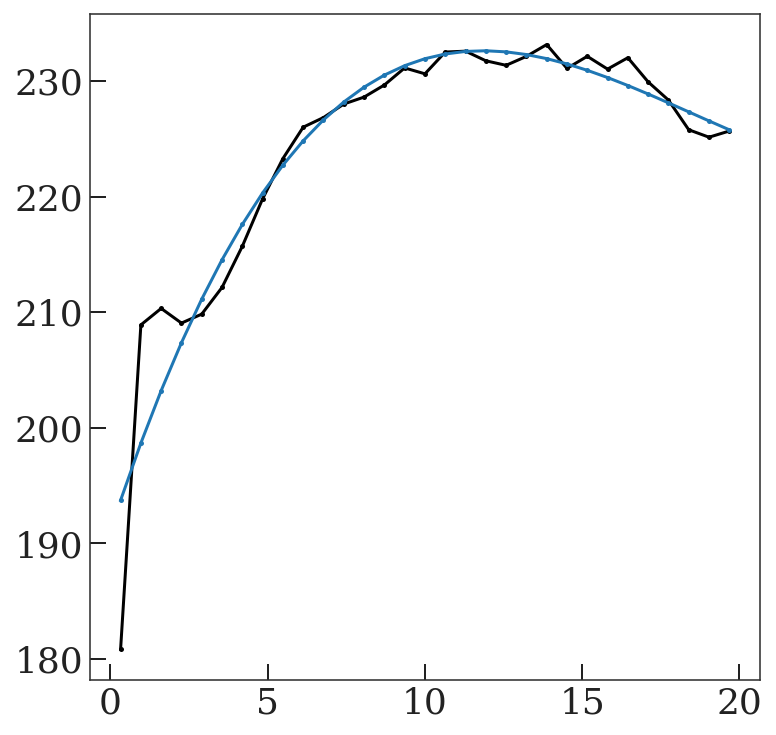

In [4]:
vc_stat = binned_statistic(
    tbl["R"][J_mask], tbl["v_phi"][J_mask], bins=np.linspace(0, 20, 32)
)
xc = 0.5 * (vc_stat.bin_edges[:-1] + vc_stat.bin_edges[1:])

plt.plot(xc, vc_stat.statistic)

vc_poly = np.polynomial.Polynomial.fit(xc, vc_stat.statistic, deg=3)
plt.plot(xc, vc_poly(xc))

In [5]:
vc = vc_poly(tbl["R"])

In [6]:
tbl["Rg"] = tbl["J"][:, 1] / vc

In [7]:
R0 = 7.5
Jphi0 = vc_poly(R0) * R0

mask = (
    (np.abs(tbl["R"] - tbl["Rg"]) < 1.5)
    # & (np.abs(tbl["R"] - R0) < 1)
    & (np.abs(tbl["v_R"]) < 20)
    & (np.abs(tbl["xyz"][:, 0] - -R0) < 1.5)
    & (np.abs(tbl["xyz"][:, 1]) < 1.5)
)
print(mask.sum())

1342451


(-7.794124246584357, 163.67663263711412)

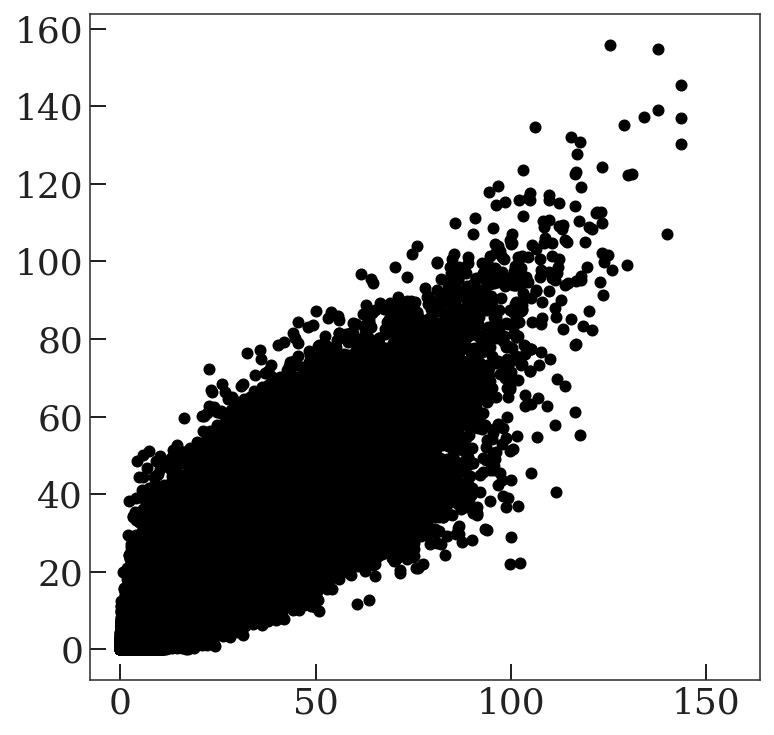

In [8]:
plt.scatter(tbl["J"][mask, 2], tbl["init_J"][mask, 2])
plt.xlim(plt.ylim())

In [9]:
pdata = tbl[mask]

In [10]:
with u.set_enabled_equivalencies(u.dimensionless_angles()):
    zmax = np.sqrt(2 * pdata["init_J"][:, 2] / pdata["init_Omega"][:, 2])
    # zmax = np.sqrt(2 * act["init_J"][mask, 2] / act["init_Omega"][mask, 2])
#     zmax = np.sqrt(2 * act["J"][mask, 2] / act["Omega"][mask, 2])

sim_mgfe_std = 0.05
rng = np.random.default_rng(seed=42)
pdata["mgfe"] = rng.normal(0.064 * zmax + 0.009, sim_mgfe_std)

pdata["z"] = pdata["xyz"][:, 2]
pdata["v_z"] = (pdata["vxyz"][:, 2] * u.km / u.s).decompose(galactic).value

In [11]:
oti_data = oti.OTIData(
    pos=pdata["z"],
    vel=pdata["v_z"],
    #     labels=dict(mgfe=pdata["mgfe"], init_Jz=pdata["J"][:, 2]),
    labels=dict(mgfe=pdata["mgfe"], init_Jz=pdata["init_J"][:, 2]),
)

In [70]:
init_Omega = 0.077 * u.rad / u.Myr

# max_z = 2.5 * u.kpc
# max_vz = 100.0 * u.km / u.s

max_z = np.round(2 * np.nanpercentile(oti_data.pos.to(u.kpc), 99), 1)
max_vz = np.round(2 * np.nanpercentile(oti_data.vel.to(u.km / u.s), 99), 0)
max_z, max_vz

(<Quantity 2.3 kpc>, <Quantity 108. km / s>)

In [71]:
max_re = np.mean(
    [
        (max_z * np.sqrt(init_Omega)).decompose(galactic).value,
        (max_vz / np.sqrt(init_Omega)).decompose(galactic).value,
    ]
)
max_re

0.5181343851443034

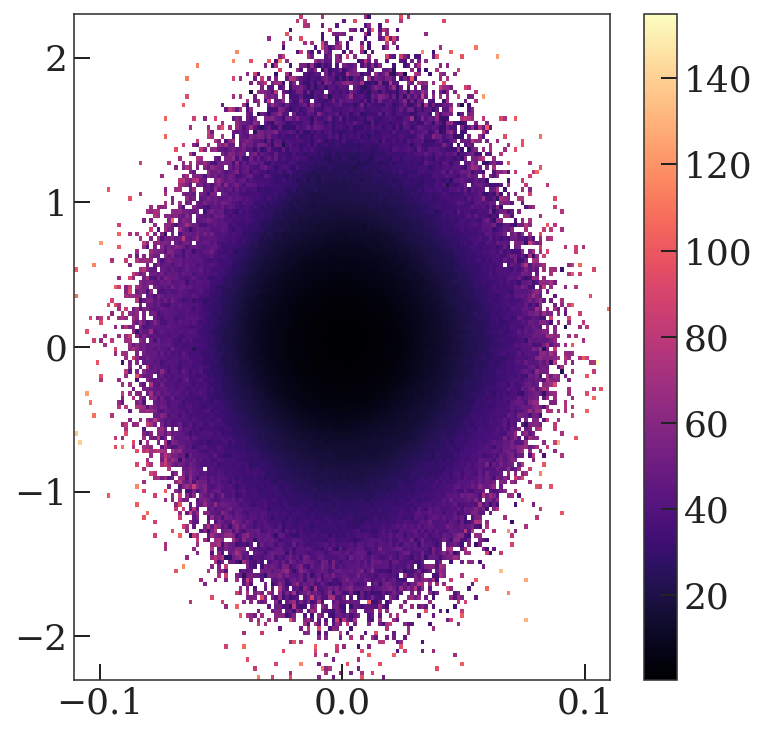

In [72]:
zbins = np.linspace(-max_z.value, max_z.value, 151) * u.kpc
vzbins = np.linspace(-max_vz.value, max_vz.value, 151) * u.km / u.s
zvz_bins = {"pos": zbins, "vel": vzbins}

tdata, _ = oti_data.get_binned_label(bins=zvz_bins, label_name="init_Jz")
plt.pcolormesh(tdata["vel"].value, tdata["pos"].value, tdata["init_Jz"])
plt.colorbar()

In [73]:
zbins = np.linspace(-max_z.value, max_z.value, 151) * u.kpc
vzbins = np.linspace(-max_vz.value, max_vz.value, 151) * u.km / u.s
zvz_bins = {"pos": zbins, "vel": vzbins}

cdata = oti_data.get_binned_counts(zvz_bins)
bdata, _ = oti_data.get_binned_label(bins=zvz_bins, label_name="mgfe")
bdata["mgfe_err"] = sim_mgfe_std / np.sqrt(cdata["counts"])

/tmp/ipykernel_2425764/3906631783.py:7: RuntimeWarning: divide by zero encountered in true_divide
  bdata["mgfe_err"] = sim_mgfe_std / np.sqrt(cdata["counts"])


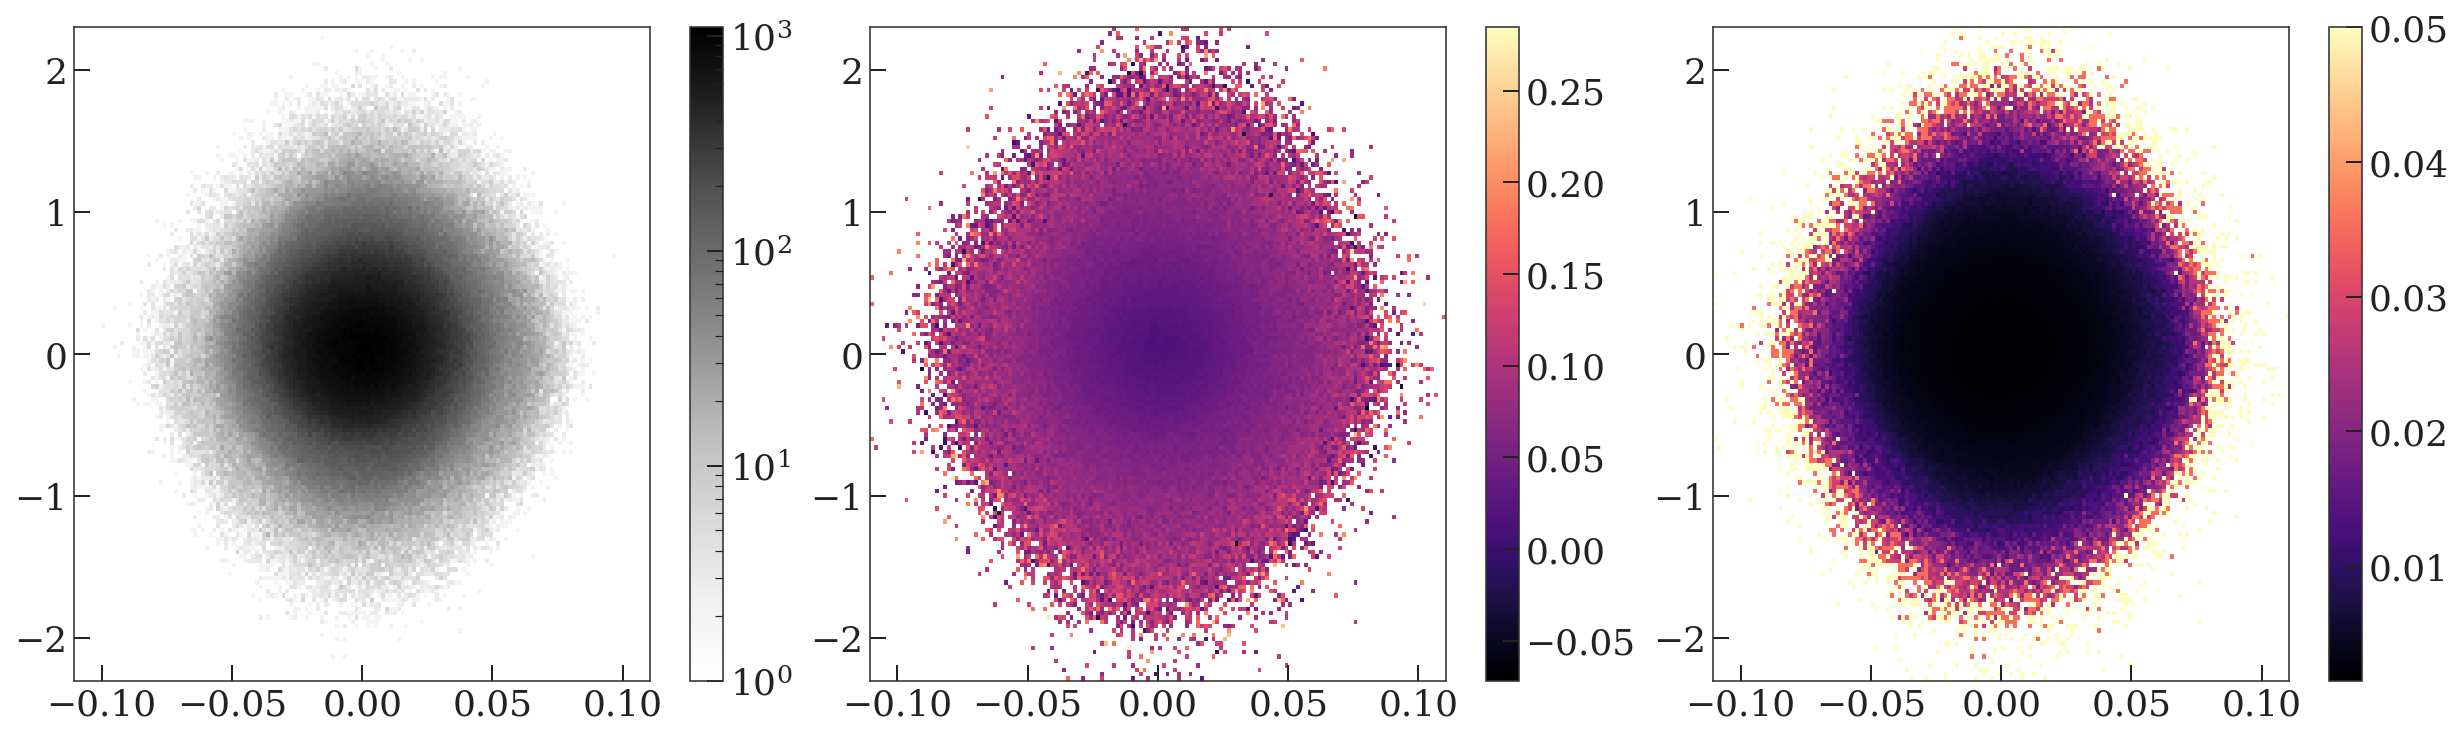

In [74]:
res = oti_data.get_binned_counts(zvz_bins)

fig, axes = plt.subplots(1, 3, figsize=(17, 5), constrained_layout=True)
cs = axes[0].pcolormesh(
    bdata["vel"].value,
    bdata["pos"].value,
    cdata["counts"],
    norm=mpl.colors.LogNorm(),
    cmap="Greys",
)
fig.colorbar(cs, ax=axes[0])

cs = axes[1].pcolormesh(bdata["vel"].value, bdata["pos"].value, bdata["mgfe"])
fig.colorbar(cs, ax=axes[1])

cs = axes[2].pcolormesh(bdata["vel"].value, bdata["pos"].value, bdata["mgfe_err"])
fig.colorbar(cs, ax=axes[2])

In [17]:
model = SplineLabelModelWrapper(
    r_e_max=max_re,
    label_n_knots=9,
    label0_bounds=(-1.0, 1.0),
    label_grad_sign=1.0,
    label_regularize_sigma=1.0,
    label_smooth_sigma=0.2,
    e_n_knots={2: 8, 4: 4},
    e_knots_scale={2: (lambda x: x ** (3 / 2), lambda x: x ** (2 / 3))},
    e_regularize_sigmas={2: 0.1, 4: 0.1, 6: 0.1},
    e_smooth_sigmas={2: 0.2, 4: 0.2, 6: 0.2},
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [18]:
p0 = model.get_init_params(oti_data, "mgfe")
p0["e_params"][2]["vals"] = np.full(len(p0["e_params"][2]["vals"]), 0.2 / max_re)
if 4 in p0["e_params"]:
    p0["e_params"][4]["vals"] = np.full(len(p0["e_params"][4]["vals"]), 0.05 / max_re)
if 6 in p0["e_params"]:
    p0["e_params"][6]["vals"] = np.full(len(p0["e_params"][6]["vals"]), 0.02 / max_re)
p0

{'pos0': 0.05231681,
 'vel0': 0.00084325357,
 'ln_Omega0': -2.9427967,
 'e_params': {2: {'vals': array([0.37654794, 0.37654794, 0.37654794, 0.37654794, 0.37654794,
          0.37654794, 0.37654794])},
  4: {'vals': array([0.09413699, 0.09413699, 0.09413699])}},
 'label_params': {'label_vals': array([0.01860344, 0.33811667, 0.33811667, 0.33811667, 0.33811667,
         0.33811667, 0.33811667, 0.33811667, 0.33811667])}}

In [19]:
np.concatenate([np.atleast_1d(x) for x in jax.tree_util.tree_flatten(p0)[0]]).size

22

In [20]:
bdata, res = model.run(
    bdata,
    p0=p0,
    label_name="mgfe",
    bins=zvz_bins,
    jaxopt_kw=dict(maxiter=32768, tol=1e-10)
    #     jaxopt_kw=dict(maxiter=16384),
)

In [21]:
res.state.success, res.state.iter_num

(True, 4267)

In [22]:
res.params

{'e_params': {2: {'vals': Array([-1.40017164, -1.37449534, -1.37419559, -1.3788263 , -1.44078213,
          -1.43040358, -1.4243691 ], dtype=float64)},
  4: {'vals': Array([-2.3223682 , -2.30607559, -2.30109095], dtype=float64)}},
 'label_params': {'label_vals': Array([0.01252455, 0.2102954 , 0.28579331, 0.2682274 , 0.23209943,
         0.19011826, 0.30435496, 0.24036481, 0.22851242], dtype=float64)},
 'ln_Omega0': Array(-2.85033253, dtype=float64),
 'pos0': Array(0.05300127, dtype=float64),
 'vel0': Array(0.00109793, dtype=float64)}

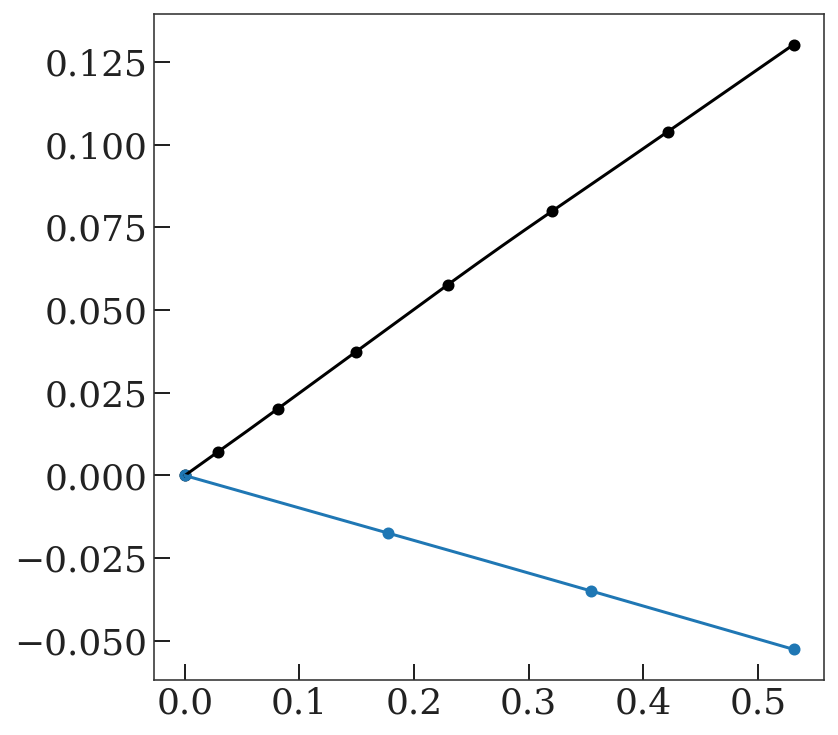

In [23]:
r_e_grid = np.linspace(0, max_re, 128)
e_vals = model.label_model.get_es(r_e_grid, res.params["e_params"])

for m, vals in e_vals.items():
    (l,) = plt.plot(r_e_grid, vals, marker="")
    plt.scatter(
        model.e_knots[m],
        model.label_model.e_funcs[m](
            model.e_knots[m], res.params["e_params"][m]["vals"]
        ),
        color=l.get_color(),
    )

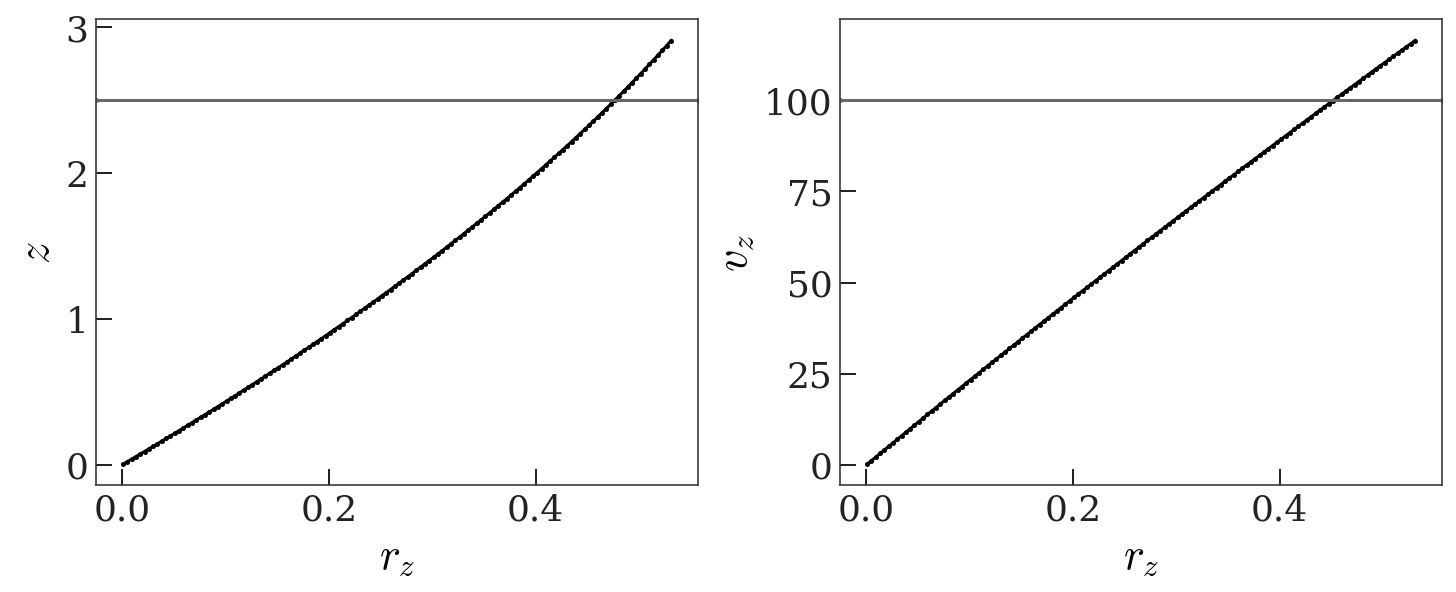

In [24]:
r_grid = np.linspace(1e-3, 1.0, 128) * max_re
shit = np.array([model.label_model.get_pos(rr, np.pi / 2, res.params) for rr in r_grid])
fuck = np.array([model.label_model.get_vel(rr, 0.0, res.params) for rr in r_grid])

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4), layout="constrained")

ax = axes[0]
ax.plot(r_grid, shit)
ax.axhline(max_z.value)
ax.set_ylabel("$z$")

ax = axes[1]
ax.plot(r_grid, (fuck * u.kpc / u.Myr).to_value(u.km / u.s))
ax.axhline(max_vz.to_value(u.km / u.s))
ax.set_ylabel("$v_z$")

for ax in axes:
    ax.set_xlabel("$r_z$")

In [25]:
r_e, _ = model.label_model.get_elliptical_coords(oti_data.pos, oti_data.vel, res.params)
r_e.max()

Array(0.67680625, dtype=float64)

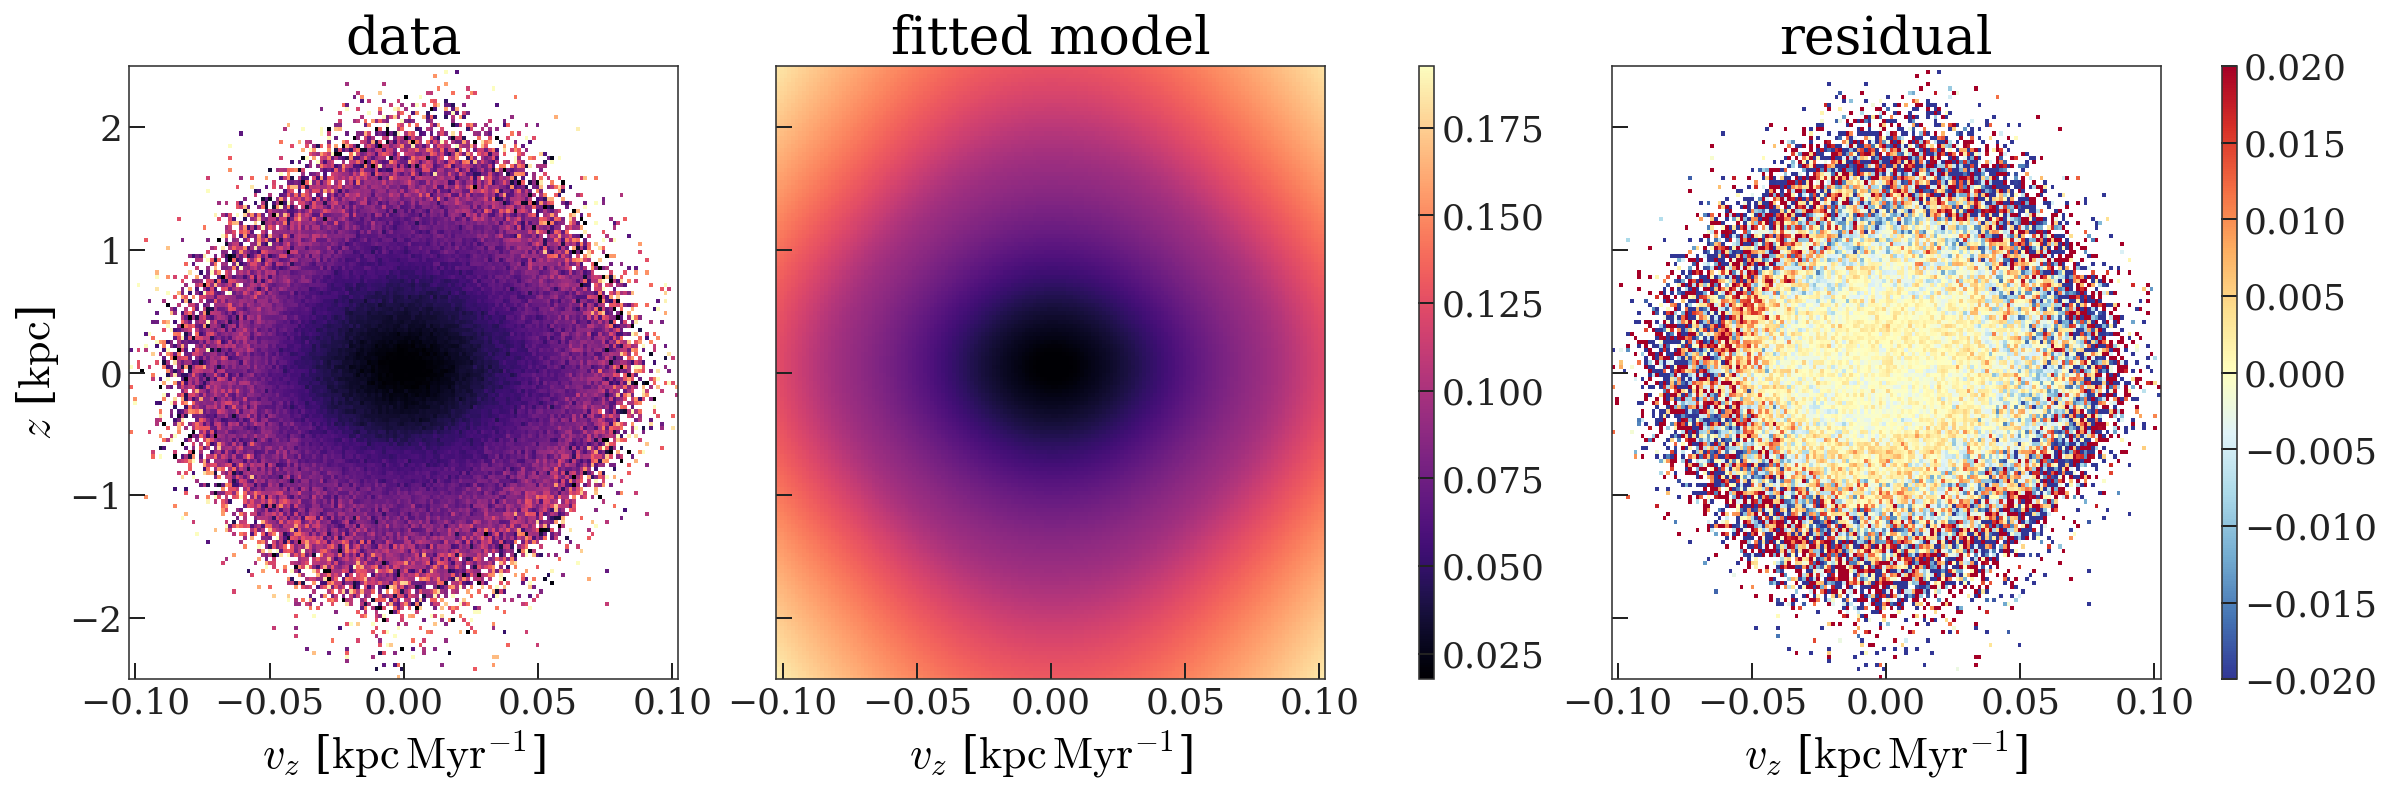

In [26]:
fig, axes = oti.plot.plot_data_models_residual(
    bdata,
    model.label_model,
    res.params,
    label_name="mgfe",
    fractional_residual=False,
    vlim_residual=0.02,
)

(-2.5, 2.5)

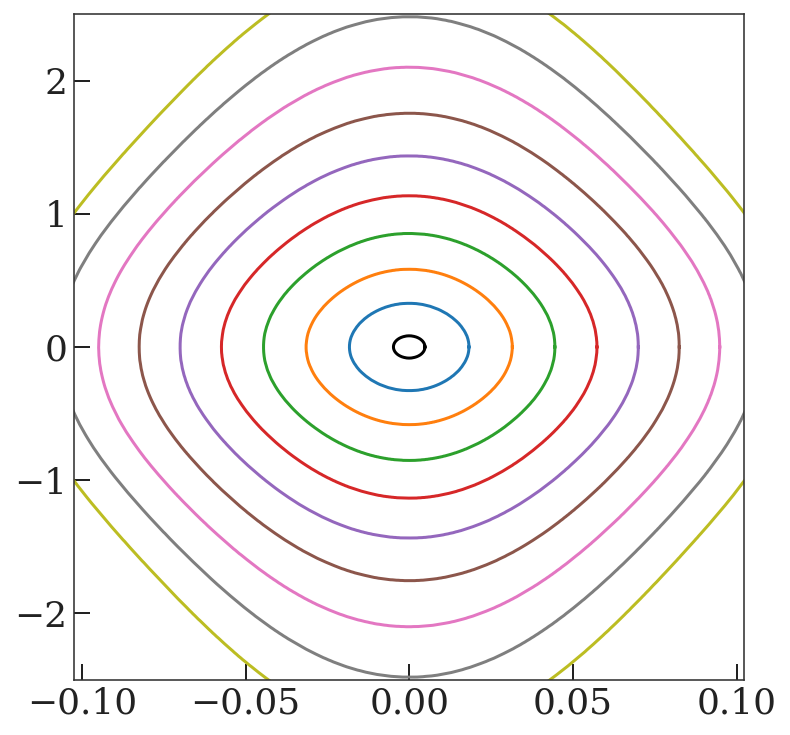

In [27]:
get_pos_vec = jax.vmap(model.label_model.get_pos, in_axes=[None, 0, None])
get_vel_vec = jax.vmap(model.label_model.get_vel, in_axes=[None, 0, None])

th_e = np.linspace(0, 2 * np.pi, 1024)

for r in np.linspace(0.02, max_re, 10):
    pp = get_pos_vec(r, th_e, res.params)
    vv = get_vel_vec(r, th_e, res.params)
    plt.plot(vv, pp, marker="")

plt.xlim(-max_vz.decompose(galactic).value, max_vz.decompose(galactic).value)
plt.ylim(-max_z.decompose(galactic).value, max_z.decompose(galactic).value)

In [28]:
Omega = np.exp(res.params["ln_Omega0"]) * u.rad / u.Myr

(-2.5, 2.5)

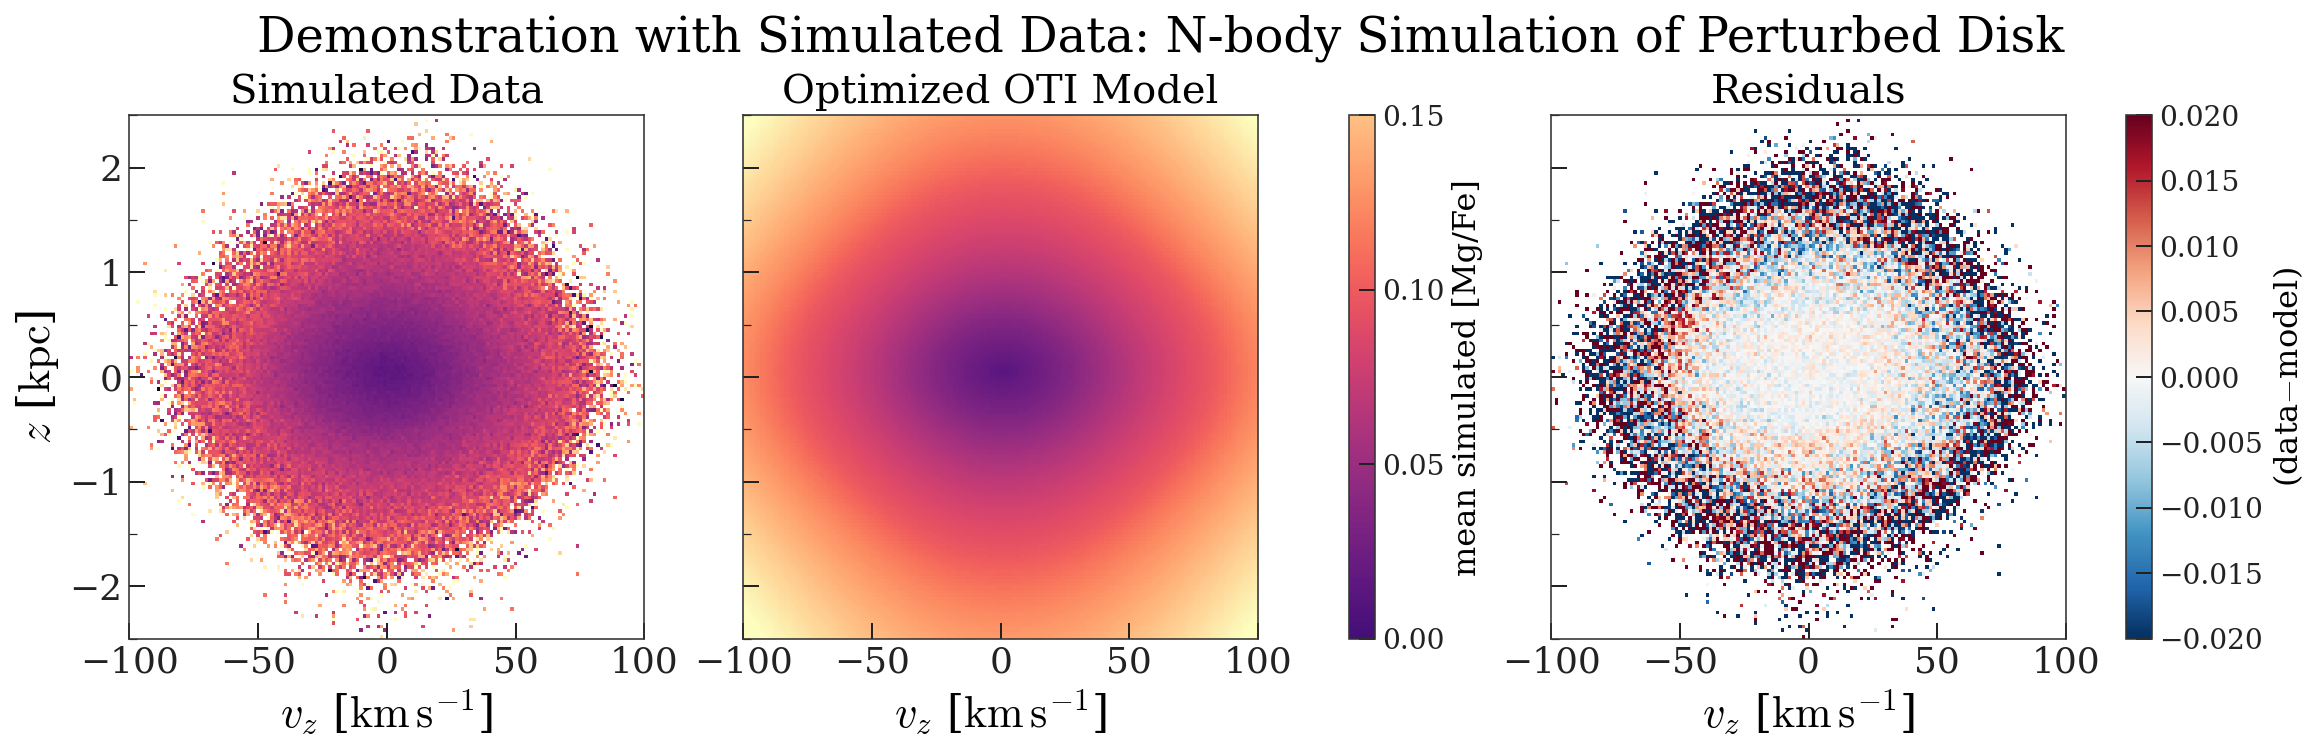

In [58]:
cb_labelsize = 16

fig, axes = plt.subplots(
    1, 3, figsize=(16, 5.1), sharex=True, sharey=True, layout="constrained"
)

cs = axes[0].pcolormesh(
    bdata["vel"].to_value(u.km / u.s),
    bdata["pos"].to_value(u.kpc),
    bdata["mgfe"],
    cmap="magma",
    rasterized=True,
    vmin=mgfe_cbar_vlim[0],
    vmax=mgfe_cbar_vlim[1],
)
cb = fig.colorbar(cs, ax=axes[0:2])  # , orientation="horizontal", aspect=40)
cb.set_label("mean simulated [Mg/Fe]", fontsize=cb_labelsize)
cb.ax.set_ylim(mgfe_cbar_xlim)
cb.ax.set_yticks(np.arange(mgfe_cbar_xlim[0], mgfe_cbar_xlim[1] + 1e-3, 0.05))
cb.ax.yaxis.set_tick_params(labelsize=14)


model_mgfe = np.array(model.label_model.label(bdata["pos"], bdata["vel"], res.params))
cs = axes[1].pcolormesh(
    bdata["vel"].to_value(u.km / u.s),
    bdata["pos"].to_value(u.kpc),
    model_mgfe,
    cmap="magma",
    rasterized=True,
    vmin=mgfe_cbar_vlim[0],
    vmax=mgfe_cbar_vlim[1],
)
# cb = fig.colorbar(cs, ax=axes[1], orientation="horizontal")
# cb.set_label("number density", fontsize=cb_labelsize)

cs = axes[2].pcolormesh(
    bdata["vel"].to_value(u.km / u.s),
    bdata["pos"].to_value(u.kpc),
    bdata["mgfe"] - model_mgfe,
    cmap="RdBu_r",
    #     vmin=-0.05,
    #     vmax=0.05,
    vmin=-0.02,
    vmax=0.02,
    rasterized=True,
)
cb = fig.colorbar(cs, ax=axes[2])  # , orientation="horizontal")
cb.set_label("(data$-$model)", fontsize=cb_labelsize)
cb.ax.yaxis.set_tick_params(labelsize=14)

# Titles
axes[0].set_title("Simulated Data", fontsize=20)
axes[1].set_title("Optimized OTI Model", fontsize=20)
axes[2].set_title("Residuals", fontsize=20)
fig.suptitle(
    "Demonstration with Simulated Data: N-body Simulation of a Perturbed Disk",
    fontsize=24,
)

# Labels
axes[0].set_ylabel(f"$z$ [{u.kpc:latex_inline}]")
for ax in axes:
    ax.set_xlabel(f"$v_z$ [{u.km/u.s:latex_inline}]")

# Ticks
axes[0].set_xticks(np.arange(-100, 100 + 1, 50))
axes[0].set_xticks(np.arange(-100, 100 + 1, 50), minor=True)
axes[1].set_yticks(np.arange(-3, 3 + 1e-3, 1))
axes[1].set_yticks(np.arange(-3, 3 + 1e-3, 0.5), minor=True)

axes[0].set_xlim(-100, 100)
axes[0].set_ylim(-2.5, 2.5)

# for ax in axes:
#     ax.set_aspect(2 * np.pi / Omega.value)

# fig.savefig(
#     "../tex/figures/jason-data-model.pdf", dpi=250, pad_inches=0.1, bbox_inches="tight"
# )

In [45]:
zgrid = np.linspace(-2.5, 2.5, 512) * u.kpc
a_unit = u.km / u.s / u.Myr

In [46]:
# states, mcmc_samples = model.run_mcmc(bdata, p0=res.params, label_name="mgfe")

Error samples:

In [ ]:
tmp_data = bdata.copy()
tmp_data["label"] = tmp_data.pop("mgfe")
tmp_data["label_err"] = tmp_data.pop("mgfe_err")
tmp_mask = np.logical_and.reduce([np.isfinite(tmp_data[k]) for k in tmp_data])
tmp_data = {k: tmp_data[k][tmp_mask] for k in tmp_data}

errs = model.label_model.error_propagate_uncertainty(res.params, tmp_data)
errs

In [ ]:
# M = model.label_model.get_crlb(res.params, tmp_data)  # , inv=True)

# plt.figure(figsize=(6, 5))
# plt.imshow(M, norm=mpl.colors.SymLogNorm(1e-8, vmin=-1e0, vmax=1e0), cmap="RdBu")
# plt.colorbar()

In [ ]:
par_samples = model.label_model.get_crlb_error_samples(res.params, tmp_data, size=1024)

In [ ]:
oti_accs = []
for p in par_samples:
    acc = model.label_model.get_acceleration(zgrid, p)
    oti_accs.append(acc.value)
oti_accs = oti_accs * acc.unit

In [ ]:
err_prop_err = (
    np.diff(np.nanpercentile(oti_accs.T, [16, 84], axis=1).to_value(a_unit), axis=0)[0]
    / 2
)

Bootstrap trials:

In [40]:
rng = np.random.default_rng(seed=8675309)
trials = []
for trial in range(32):
    trial_idx = rng.choice(len(oti_data), size=len(oti_data), replace=True)

    tmp_cdata = oti_data[trial_idx].get_binned_counts(zvz_bins)
    tmp_bdata, _ = oti_data[trial_idx].get_binned_label(
        bins=zvz_bins, label_name="mgfe"
    )
    tmp_bdata["mgfe_err"] = sim_mgfe_std / np.sqrt(tmp_cdata["counts"])

    _, trial_res = model.run(
        tmp_bdata,
        p0=res.params,
        bins=zvz_bins,
        label_name="mgfe",
        jaxopt_kw=dict(maxiter=4096, tol=1e-8),
    )
    trials.append(trial_res)

/tmp/ipykernel_2425764/3386383393.py:8: RuntimeWarning: divide by zero encountered in true_divide
  tmp_bdata["mgfe_err"] = sim_mgfe_std / np.sqrt(tmp_cdata["counts"])
/tmp/ipykernel_2425764/3386383393.py:8: RuntimeWarning: divide by zero encountered in true_divide
  tmp_bdata["mgfe_err"] = sim_mgfe_std / np.sqrt(tmp_cdata["counts"])
/tmp/ipykernel_2425764/3386383393.py:8: RuntimeWarning: divide by zero encountered in true_divide
  tmp_bdata["mgfe_err"] = sim_mgfe_std / np.sqrt(tmp_cdata["counts"])
/tmp/ipykernel_2425764/3386383393.py:8: RuntimeWarning: divide by zero encountered in true_divide
  tmp_bdata["mgfe_err"] = sim_mgfe_std / np.sqrt(tmp_cdata["counts"])
/tmp/ipykernel_2425764/3386383393.py:8: RuntimeWarning: divide by zero encountered in true_divide
  tmp_bdata["mgfe_err"] = sim_mgfe_std / np.sqrt(tmp_cdata["counts"])
/tmp/ipykernel_2425764/3386383393.py:8: RuntimeWarning: divide by zero encountered in true_divide
  tmp_bdata["mgfe_err"] = sim_mgfe_std / np.sqrt(tmp_cdata["co

In [41]:
bootstrap_accs = []
for trial_res in trials:
    acc = model.label_model.get_acceleration(zgrid, trial_res.params)
    bootstrap_accs.append(acc.value)
bootstrap_accs = bootstrap_accs * acc.unit

In [42]:
bootstrap_err = np.std(bootstrap_accs.to_value(a_unit), axis=0)

Total:

In [43]:
xyz_grid = np.zeros((3, zgrid.size)) * u.kpc
xyz_grid[0] = R0 * u.kpc
xyz_grid[2] = zgrid

In [44]:
total_acc_err = np.sqrt(err_prop_err**2 + bootstrap_err**2) * a_unit
# total_acc_err = bootstrap_err * a_unit
# total_acc_err = err_prop_err * a_unit

TODO: What units are these accelerations in??

In [51]:
with open("/mnt/home/jhunt/ceph/Bonsai/r2/B2/AdrianAccel702.p", "rb") as f:
    rrt, zzt, ppt, accelt = pickle.load(f)

In [52]:
grid_r_mask = (rrt == 8.0) & np.isclose(ppt, ppt[np.argmin(np.abs(ppt - np.pi))])

In [53]:
shit = InterpolatedUnivariateSpline(zzt[grid_r_mask], accelt[grid_r_mask, 2])
fuck = InterpolatedUnivariateSpline(zgrid.value, bestfit_acc.to_value(a_unit))
norm = np.mean([shit(0.5) / fuck(0.5), shit(-0.5) / fuck(-0.5)])
print(norm)

true_zz = zzt[grid_r_mask]
true_acc = accelt[grid_r_mask, 2] / norm

205225517.83263916


TODO: interpolate true acc

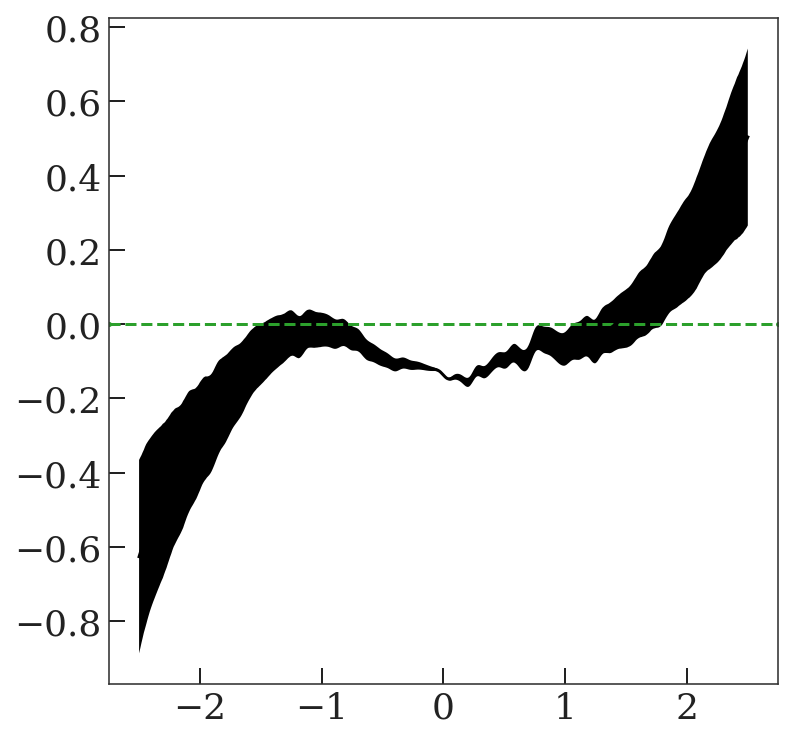

In [61]:
bestfit_acc = model.label_model.get_acceleration(zgrid, res.params)

true_acc_interp = InterpolatedUnivariateSpline(true_zz, true_acc)
dacc = bestfit_acc.to_value(a_unit) - true_acc_interp(zgrid)

plt.axhline(0.0, ls="--", color="tab:green")
plt.plot(zgrid.value, dacc, marker="", color="k")
plt.fill_between(
    zgrid.value,
    dacc - total_acc_err.to_value(a_unit),
    dacc + total_acc_err.to_value(a_unit),
)
# plt.fill_between(
#     zgrid.value,
#     (np.nanpercentile(oti_accs.T, 16, axis=1) - true_acc[2]).to_value(a_unit),
#     (np.nanpercentile(oti_accs.T, 84, axis=1) - true_acc[2]).to_value(a_unit),
# )
# plt.ylim(-0.1, 0.1)

In [55]:
# (aaf_idx,) = np.where(mask)
aaf_idx = np.arange(len(pdata))

rng = np.random.default_rng(seed=123)
aaf_idx = rng.choice(aaf_idx, size=100_000, replace=False)
aaf = model.label_model.compute_action_angle(
    pdata["z"][aaf_idx] * u.kpc, pdata["v_z"][aaf_idx] * u.kpc / u.Myr, res.params
)

In [56]:
Junit = u.km / u.s * u.kpc

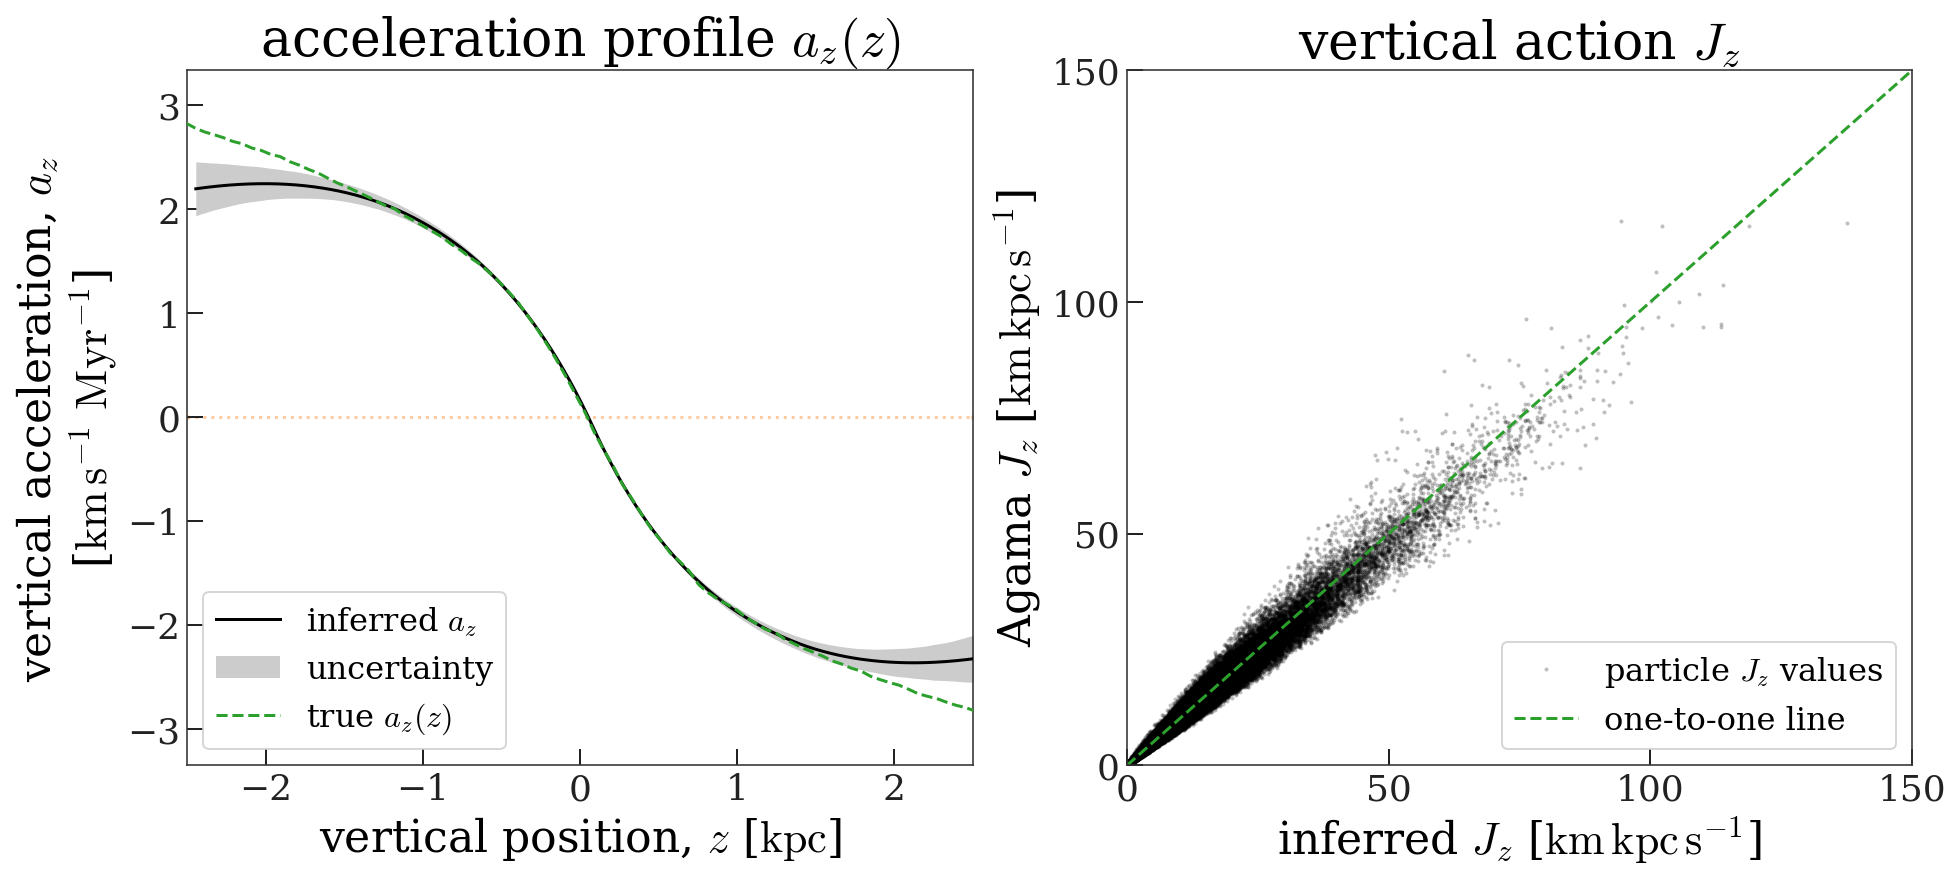

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(13.5, 6.0), layout="constrained")

ax = axes[0]
ax.plot(
    zgrid.value + res.params["pos0"],
    bestfit_acc.to_value(a_unit),
    color="k",
    marker="",
    label="inferred $a_z$",
    zorder=10,
)
ax.fill_between(
    zgrid.value + res.params["pos0"],
    (bestfit_acc - total_acc_err).to_value(a_unit),
    (bestfit_acc + total_acc_err).to_value(a_unit),
    color="#cccccc",
    lw=0,
    label=r"uncertainty",
    zorder=2,
)

ax.plot(
    true_zz,
    true_acc,
    ls="--",
    color="tab:green",
    marker="",
    label=r"true $a_z(z)$",
    zorder=15,
)
ax.set_xlim(zgrid.value.min(), zgrid.value.max())
# ax.set_ylim(
#     1.4 * true_acc[2].min().to_value(a_unit), 1.4 * true_acc[2].max().to_value(a_unit)
# )
ax.axhline(0, zorder=-10, color="tab:orange", alpha=0.4, ls=":")
ax.legend(loc="lower left", fontsize=16)

ax.set_xlabel(f"vertical position, $z$ [{u.kpc:latex}]")
ax.set_ylabel(
    f"vertical acceleration, $a_z$\n[{u.km/u.s:latex_inline} {u.Myr**-1:latex_inline}]"
)
ax.set_title("acceleration profile $a_z(z)$")

ax = axes[1]
ax.plot(
    aaf["J"].to_value(Junit),
    pdata["J"][aaf_idx, 2],
    marker="o",
    ls="none",
    alpha=0.25,
    mew=0,
    ms=2.0,
    label="particle $J_z$ values",
    rasterized=True,
)
ax.axline(
    [0, 0],
    [
        pdata["J"][aaf_idx, 2].max(),
        pdata["J"][aaf_idx, 2].max(),
    ],
    ls="--",
    color="tab:green",
    marker="",
    label="one-to-one line",
)
ax.set_xlim(0, pdata["J"][aaf_idx, 2].max())
ax.set_ylim(0, pdata["J"][aaf_idx, 2].max())
ax.set_title("vertical action $J_z$")

ax.legend(loc="lower right", fontsize=16)

ax.set_xlabel(f"inferred $J_z$ [{Junit:latex_inline}]")
ax.set_ylabel(f"Agama $J_z$ [{Junit:latex_inline}]")
ax.set_xticks(np.arange(0, 200, 50))
ax.set_yticks(np.arange(0, 200, 50))

# fig.savefig("../tex/figures/jason-validation.pdf", dpi=250)

In [57]:
res.params

{'e_params': {2: {'vals': Array([-1.40017164, -1.37449534, -1.37419559, -1.3788263 , -1.44078213,
          -1.43040358, -1.4243691 ], dtype=float64)},
  4: {'vals': Array([-2.3223682 , -2.30607559, -2.30109095], dtype=float64)}},
 'label_params': {'label_vals': Array([0.01252455, 0.2102954 , 0.28579331, 0.2682274 , 0.23209943,
         0.19011826, 0.30435496, 0.24036481, 0.22851242], dtype=float64)},
 'ln_Omega0': Array(-2.85033253, dtype=float64),
 'pos0': Array(0.05300127, dtype=float64),
 'vel0': Array(0.00109793, dtype=float64)}

In [61]:
(1 * u.kpc / u.Myr**2).to(u.km / u.s / u.Myr)

<Quantity 977.79222168 km / (Myr s)>

In [67]:
truth = {
    "J": pdata["J"][:, 2][aaf_idx] * Junit,
    "theta": pdata["theta"][:, 2][aaf_idx] * u.rad,
    "Omega": pdata["Omega"][:, 2][aaf_idx] * u.rad / u.Gyr,
}

for k in ["J", "theta", "Omega"]:
    if k == "theta":
        frac_diff = (
            ((np.cos(aaf[k]) - np.cos(truth[k])) / np.cos(truth[k])).decompose().value
        )
    else:
        frac_diff = ((aaf[k] - truth[k]) / truth[k]).decompose().value
    print(k, np.median(np.abs(frac_diff)))

J 0.10901720196548112
theta 0.06423338019104813
Omega 0.1273973220973615
